# Fundamentos de Aprendizaje Automático y Reconocimiento de Patrones
# Práctico 2

In [3]:
# Se importan las biblotecas que se van a utilizar
import numpy as np
from matplotlib import pyplot as plt
import time
import h5py  # es el formato en el que están almacenados los dígitos


import gradio as gr  # se utiliza en la evaluación interactiva
from scipy.ndimage import interpolation

from visualizacion import visualizar_conjunto_entrenamiento, visualizar_modelo_lineal
from algoritmos import entrenar_perceptron
from fuaa_utils import validar_resultado

plt.rcParams['figure.figsize'] = (10.0, 10.0
                                  )  # tamaño de las figuras por defecto
# el inline sirve para que las figuras se muestren dentro del notebook
%matplotlib inline

# Se agrega para que el notebook vea los cambios realizados en los modulos que utiliza;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2

## Objetivos

Los objetivos de este práctico son los siguientes:
    
- Fortalecer el conocimiento del **modelo lineal** mediante la formulación de las ecuaciones que permiten encontrar sus parámetros.
- Implementar la **regresión lineal** y utilizarla para resolver un problema de **regresión** y uno de **clasificación**.
- Implementar el **algoritmo pocket**. Comparar su desempeño con el de regresión lineal para clasificación.
- Separar un conjunto de datos **no linealmente separables** utilizando **clasificadores lineales** mediante la transformación de características. 
- Desarrollar un **clasificador de dígitos**.

*** 

## Lista de ejercicios

[Ejercicio 1](#Ejercicio1): modelo de regresión lineal y su implementación.        
[Ejercicio 2](#Ejercicio2): clasificación de datos sintéticos mediante regresión lineal y el algoritmo pocket. Transformación de características.      
[Ejercicio 3](#Ejercicio3): clasificación de dígitos.       


# Ejercicio 1: Regresión Lineal
<a id="Ejercicio1"></a>

En esta parte se trabajará con el conjunto de datos *Advertising* que almacena las ventas de un producto en 200 mercados diferentes junto con lo invertido en publicidad en diferentes medios de prensa: televisión, radio y prensa escrita. El objetivo es determinar la relación que existe entre las ventas y lo invertido en publicidad asumiendo un modelo lineal.

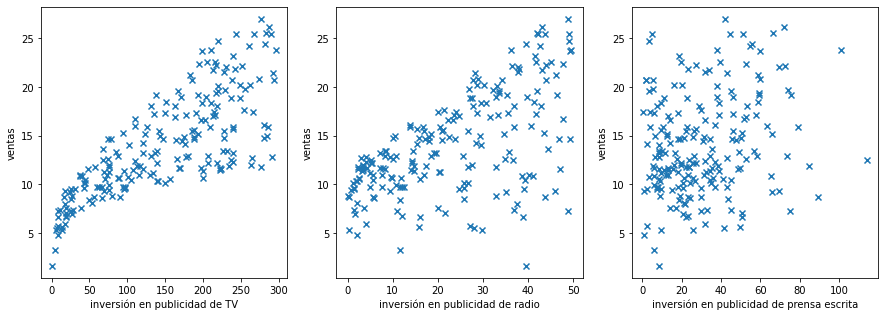

In [4]:
X_names = ['TV', 'radio', 'prensa escrita']
y_name = ['ventas']

##################################################
########  EMPIEZA ESPACIO PARA COMPLETAR  ########
##################################################

# utilizar la función de numpy loadtxt() para cargar los datos. La primera
# fila no tiene que ser leída

data = np.loadtxt(open("Advertising.csv", "rb"), delimiter=",", skiprows=1)

##################################################
########  TERMINA ESPACIO PARA COMPLETAR  ########
##################################################

X = data[:, 0:4]
X[:, 0] = 1
y = data[:, 4:]

plt.figure(figsize=(15, 5))
for p in range(3):
    plt.subplot(1, 3, p + 1)
    plt.scatter(X[:, 1 + p], y, marker='x', label=X_names[p])
    plt.xlabel('inversión en publicidad de ' + X_names[p])
    plt.ylabel(y_name[0])

* **Pregunta:** ¿Por qué se dice que este es un problema de regresión?

**Respuesta:**  Porque no se toma una decisión binaria de invertir o no invertir en cierta publicidad, se quiere saber la relación que tienen las ventas con lo invertido en cada medio. Tenemos varias etiquetas para, no se elije una de un grupo finito. 

* **Pregunta:** Asuma que existe una relación lineal entre entradas y salida, exprese matemáticamente dicho modelo e indique claramente cuáles son las entradas y salidas del modelo. ¿Cuántos parámetros deben determinarse?

**Respuesta:**  Tomando $y=\{ventas\}$, $x=\{1,invTV,invRadio,invPrensa\}$ y $w=\{bias,pesoTV,pesoRadio,pesoPrensa\}$ se puede escribir la salida como la suma de las entradas multiplicadas por su peso como $y=\sum_{i=0}^{3}w_{i}^Tx_{i}$


* **Pregunta:** Expresar el sistema de ecuaciones a resolver y la solución al mismo bajo el criterio de mínimos cuadrados en el caso de contar con $N$ puntos. 

**Respuesta:** Se busca minimizar el error en la muestra con la fórmula $E_{in}(h)=\frac{1}{N}\sum_{i=0}^{N}(w_{i}x_{i} - y_i)²$ 


Implementar la solución anteriormente descrita en el método `regresion_lineal()`.

In [5]:
def regresion_lineal(X, y):
    '''
    Entrada:
        X: matriz de dimensión (N,d+1)
        y: arreglo de dimensión (N,1)
    Salida:
        w_ls: vector de pesos con dimensión (d+1,1) encontrado por la regresión lineal 
    '''

    #######################################################
    ######## EMPIEZA ESPACIO PARA COMPLETAR CODIGO ########
    #######################################################

    # Sugerencia: utilizar el paquete linalg de numpy
    # para calcular la inversa

    w_ls = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),y)

    #######################################################
    ######## TERMINA ESPACIO PARA COMPLETAR CODIGO ########
    #######################################################

    return w_ls

In [6]:
w_ls = regresion_lineal(X,y)

validar_resultado('p02e01', w_ls )

+-------------------------------------------------------------------------+
| FuAA: validar resultado                                                 |
+-------------------------------------------------------------------------+
 Ninguna opción revisada.
+-------------------------------------------------------------------------+


In [7]:
print(w_ls)

[[ 2.93888937e+00]
 [ 4.57646455e-02]
 [ 1.88530017e-01]
 [-1.03749304e-03]]


* **Pregunta:** Si dispusiera de $1000 para invertir en publicidad ¿En que medio lo invertiría y cómo estima que repercutiría en las ventas?

**Respuesta:**  Invertiría en radio porque es el que tiene el mayor peso. 

## Sobre la interpretabilidad del Modelo

En general cuando se realiza una interpretación de los coeficientes de un modelo se debe tener presente que pueden existir correlaciones entre las características. Esto genera dificultades en la interpretación puesto que en el caso de los modelos lineales los efectos de las características son aditivos y se vuelve indeterminable a cuál de las características correlacionadas atribuir el efecto. 

Por lo tanto, puede ocurrir que múltiples entrenamientos de un modelo obtengan desempeños similares con coeficientes distintos. Es por esta razón que los coeficientes obtenidos luego de entrenar una única vez un modelo corresponden a una única realización de los mismos. 

El objetivo del siguiente ejercicio es observar que los coeficientes obtenidos para un modelo presentan cierta variación que podría llegar a afectar la interpretación del modelo. 

Puesto que el algoritmo para hallar la regresión lineal es determinístico dado un conjunto de datos, para observar el fenómeno mencionado se genera aleatoriedad a partir de submuestrear el conjunto original y repetir el entrenamiento de un modelo 500 veces, generando así distintas realizaciones de los coeficientes.

In [8]:
# Cantidad de Muestras
N = X.shape[0]

# Cantidad de Muestras que se submuestrean
subsample_size = int(3 * N / 4)

# Cantidad de Experimentos
M = 500

# Realizaciones del submuestreo
np.random.seed(seed=42)
experiment = np.random.randint(0, N, size=(M, subsample_size))

# Lista donde guardo los pesos aprendidos en los distintos experimentos
w = []

# Lista donde guardo los errores del modelo en cada experimento
error = []

# Recorro cada submuestreo y obtengo los pesos correspondientes en cada caso
for i_exp in range(M):

    # Vector X e y sorteados en este experimento
    X_i = X[experiment[i_exp]].copy()
    y_i = y[experiment[i_exp]].copy()

    #######################################################
    ######## EMPIEZA ESPACIO PARA COMPLETAR CODIGO ########
    #######################################################

    # Coeficientes obtenidos con la regresion lineal
    w_ls_i = regresion_lineal(X_i, y_i)

    # Agregar w_ls_i a la lista
    w.append(w_ls_i)

    # Calcular el error cuadrático medio en el subconjunto muestreado
    
    err_i = pow((np.dot(X_i,w_ls)-y_i),2)

    # Agregar err_i a la lista de errores
    error.append(err_i)
    #######################################################
    ######## TERMINA ESPACIO PARA COMPLETAR CODIGO ########
    #######################################################

En la siguiente celda se observan a partir de un histograma de frecuencia relativa como varían los coeficiente del modelo para los distintos experimentos: 

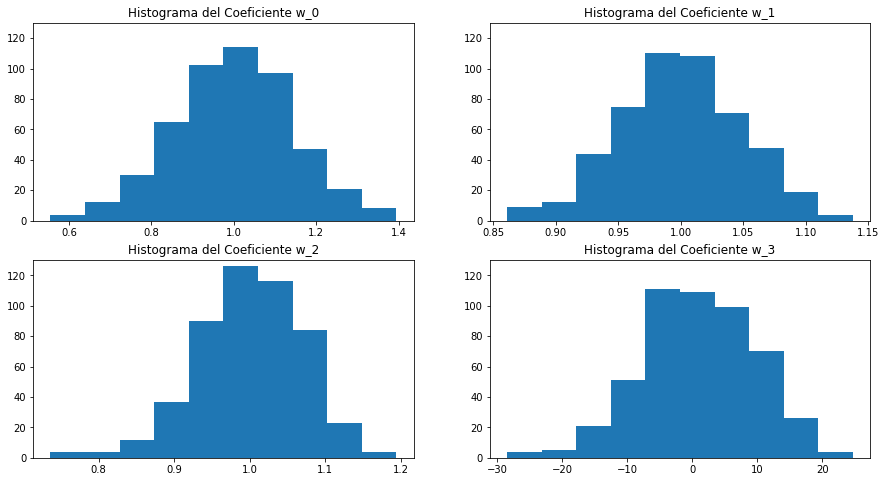

In [9]:
# Convierto la lista de pesos en una matriz
w = np.array(w).reshape((-1, 4))

# Hallo el valor promedio de los pesos
w_ls_mean = np.mean(w, axis=0)

# Histograma de los Coeficientes
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
for i, ax_i in enumerate(ax.flatten()):
    ax_i.set_title('Histograma del Coeficiente w_' +
                   str(i))  #Título del Gráfico
    ax_i.hist(w[:, i] / w_ls_mean[i])  # Grafica el histograma
    ax_i.set_ylim(0, 130)  # Define los límites a graficar en el eje Y

In [10]:
print('El error promedio cometido por los modelos es de',"{:.2f}".format(np.mean(error)), 
      ' con una desviación de', "{:.2f}".format(np.std(error)),'.')

El error promedio cometido por los modelos es de 2.79  con una desviación de 6.48 .


# Ejercicio 2: Clasificación con datos sintéticos
<a id="Ejercicio2"></a>

## Generación de datos sintéticos

Se consideran dos semianillos de ancho $w$ y radio interno $r$, separados por $sep$. El centro del semianillo superior está alineado con el centro del borde donde comienza el semianillo inferior. Los datos son linealmente separables cuando $sep > 0$ y no lo son cuando $sep \leq 0$. Generar 2000 muestras uniformemente distribuídas, aproximadamente 1000 de cada clase, utilizando un radio $r=10$, un ancho $w=5$ y una separación $sep=5$.

In [11]:
def generar_semianillos(N, radio, ancho, separacion, semilla=None):
    '''
    Entrada:
        N: número de muestras a generar
        radio: radio interior del semicírculo
        ancho: diferencia entre el radio exterior e interior
        separación: separación entre los semicírculos
        semilla: valor que se le asigna al método random.seed()

    Salida:
        X: matriz de dimensión  (N,3) que contiene los datos generados en coordenadas homogéneas
        y: etiquetas asociadas a los datos. Tienen dimensión (N,)
    '''

    if semilla is not None:
        np.random.seed(semilla)

    X = np.ones((N, 3))
    # se sortea a que clase pertenecen las muestras
    y = 2 * (np.random.rand(N) < 0.5) - 1

    # radios y ángulos del semicírculo superior
    radios = radio + ancho * np.random.rand(N)
    thetas = np.pi * np.random.rand(N)
    # coordenadas en x de ambos semicírculos
    X[:, 1] = radios * np.cos(thetas) * y + (radio + ancho / 2) * (y == -1)
    # coordenadas en y de ambos semicírculos
    X[:, 2] = radios * np.sin(thetas) * y - separacion * (y == -1)

    return X, y

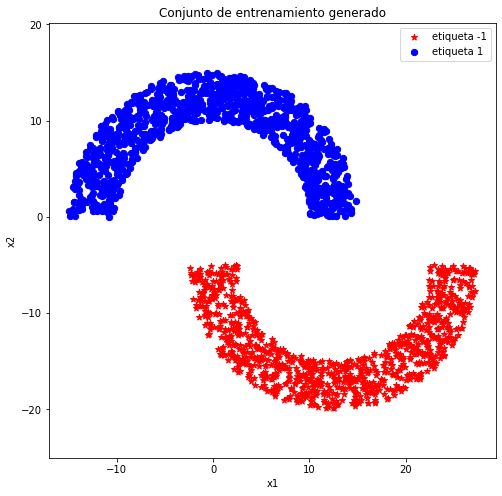

In [12]:
#######################################################
######## EMPIEZA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################

X, y = generar_semianillos(2000, 10, 5, 5, semilla=None)

#######################################################
######## TERMINA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################

visualizar_conjunto_entrenamiento(X, y)

## El perceptrón para separar clases linealmente separables

Se prové una implementación del algoritmo del perceptrón `entrenar_perceptron()` implementado en la práctica anterior. Ejecutarlo partiendo del vector de pesos inicial $\mathbf{w}=0$ hasta que converja. Mostrar los datos y la hipótesis final.

+-------------------------------------------------------------------------+
| FuAA: validar resultado                                                 |
+-------------------------------------------------------------------------+
 Ninguna opción revisada.
+-------------------------------------------------------------------------+


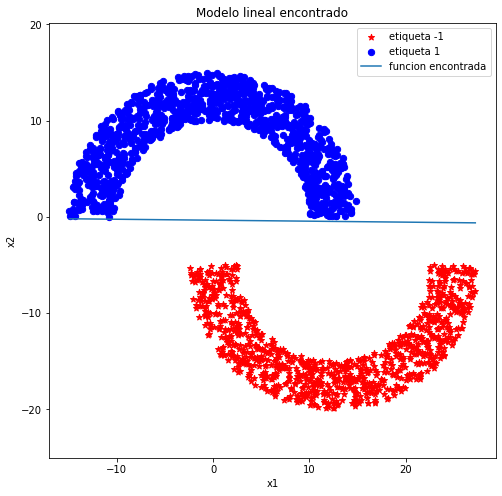

In [13]:
#######################################################
######## EMPIEZA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################

w_perceptron, error_entrenamiento = entrenar_perceptron(X, y, w_inicial=np.zeros(3), max_iter=500)

# chequear que el error de entrenamiento con el w encontrado es cero

#######################################################
######## EMPIEZA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################

# Se grafica el resultado del entrenamiento
visualizar_modelo_lineal(X, y, w_perceptron)

validar_resultado('p02e02a', w_perceptron)

## Regresión lineal como método de clasificación

Utilizar el método `regresion_lineal()` implementado anteriormente para clasificación.

+-------------------------------------------------------------------------+
| FuAA: validar resultado                                                 |
+-------------------------------------------------------------------------+
 Ninguna opción revisada.
+-------------------------------------------------------------------------+


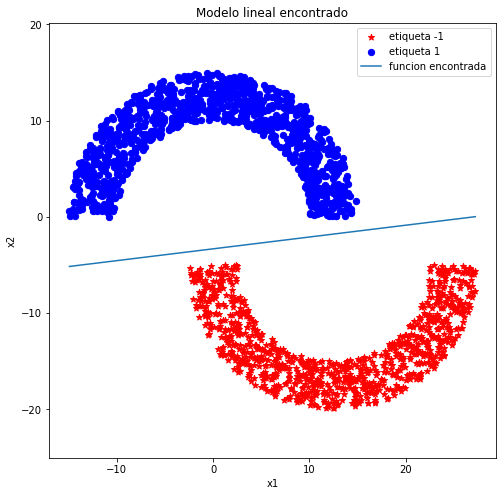

In [14]:
#######################################################
######## EMPIEZA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################

w_ls = regresion_lineal(X,y)

#######################################################
######## TERMINA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################

# Se grafica el resultado del entrenamiento utilizando regresión lineal
visualizar_modelo_lineal(X, y, w_ls)
validar_resultado('p02e02b', w_ls)

* **Pregunta:** Comente sobre las fronteras de decisión encontradas. ¿Prefiere alguna de ellas?

**Respuesta:**

Es preferible la recta encontrada por el algoritmo de regresión lineal dado que se encuentra equidistante de ambas curvas, la encontrada por el perceptrón está muy pegada a la curva azul y hasta parece dejar un punto mal clasificado.

## Datos no linealmente separables

El siguiente bloque genera un conjunto de datos con $sep=-5$ y lo grafica. 

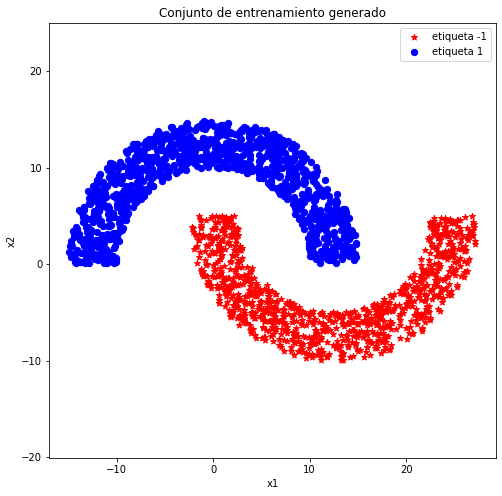

In [15]:
N = 2000
r = 10
w = 5
sep = -5
X, y = generar_semianillos(N, r, w, sep, semilla=100)

visualizar_conjunto_entrenamiento(X, y)

* **Pregunta:** Explicar qué sucede al ejecutar el algoritmo del perceptrón en dicho conjunto.

**Respuesta:** En esta situación el algoritmo del perceptrón estará variando de forma constante su recta y terminaría en su iteración máxima, obteniendo una recta que podría no ser la que menos muetras mal clasificadas deja.

<a id="algoritmoPocket"></a>
## El algoritmo pocket

La superficie de decisión obtenida mediante el *perceptrón* garantiza una adecuada separación de las dos clases solamente en el caso en que éstas son linealmente separables. Una pregunta que surge naturalmente es qué sucede cuando estas condiciones no se cumplen.  El algoritmo *pocket* es una variante del perceptrón que con cada actualización de pesos calcula el error cometido si se utiliza el nuevo vector de pesos. Al finalizar, devuelve el vector de pesos con el mínimo error.     

Completar el código del método `entrenar_pocket()`. 

In [16]:
def entrenar_pocket(X, y, w0=None, max_iter=500, semilla=None):
    """
    Entrada:
        X: matriz de tamaño (N,d+1) que contiene N muestras de 
           entrenamiento de dimensión d.
        y: arreglo de largo N que contiene las etiquetas asociadas a las 
           muestras de entrenamiento.
        w0: inicialización de los pesos del perceptrón.
        max_iter: máxima cantidad de iteraciones que el algoritmo puede 
                  estar iterando.
        semilla: valor que se le asigna al método random.seed()
        
    Salida:
        w_pocket: parámetros del modelo perceptrón   
        error: lista que contiene los errores de clasificación cometidos 
               en cada iteración utilizando el w_pocket.
    """

    if semilla is not None:
        np.random.seed(semilla)

    if w0 is None:
        # Se inicializan los pesos del perceptrón
        w = np.random.rand(X.shape[1])  # w = np.zeros(d+1)
        print('w inicializado aleatoriamente a ', w)
    else:
        w = w0
        print('El w inicial es ', w)

    N = X.shape[0]
    w_pocket = w.copy()  # se inicializa el vector de pesos a devolver
    error = []  # se inicializa la lista de errores
    hay_muestras_mal_clasificadas = True
    error_actual = 1  # inicialización del error al máximo posible
    n_iter = 0  # inicialización del contador de iteraciones
    w_actual=w0

    while ((n_iter < max_iter) and hay_muestras_mal_clasificadas):

        #######################################################
        ######## EMPIEZA ESPACIO PARA COMPLETAR CODIGO ########
        #######################################################
        w_nuevo, error_actual = entrenar_perceptron(X, y, w_inicial=w_actual, max_iter=1)
        
        if (n_iter==0):
            w_pocket=w_actual.copy()
            error.append(error_actual[0])
        elif (error_actual[0]< error[-1]):
            w_pocket=w_actual.copy()
            error.append(error_actual[0])
        elif (error_actual[0] >= error[-1]):
            error.append(error[-1])  
        if (error_actual[0]==0) :
            hay_muestras_mal_clasificadas=False
        w_actual=w_nuevo
        n_iter+=1
        
        #print('error:',error[-1])
        #print('w_pocket:',w_pocket)
        #######################################################
        ######## TERMINA ESPACIO PARA COMPLETAR CODIGO ########
        #######################################################

    if (np.array_equal(w, w_pocket)):
        print(
            'Cuidado: es poco probable que el vector de pesos devuelto sea el de la última actualización'
        )

    return w_pocket, error

Ejecutar el algoritmo pocket por 100000 iteraciones y graficar el error de entrenamiento en función del número de iteraciones.

El w inicial es  [0. 0. 0.]
175
[-146.          -13.48221234   95.31475705]
El algoritmo pocket demoró 9.767852 segundos
El pocket finalizó en la iteración 100000
El error de entrenamiento es 175.000000
+-------------------------------------------------------------------------+
| FuAA: validar resultado                                                 |
+-------------------------------------------------------------------------+
 Ninguna opción revisada.
+-------------------------------------------------------------------------+


Text(0, 0.5, 'error entrenamiento')

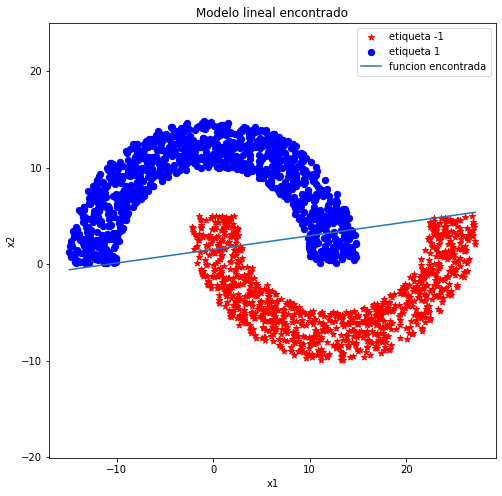

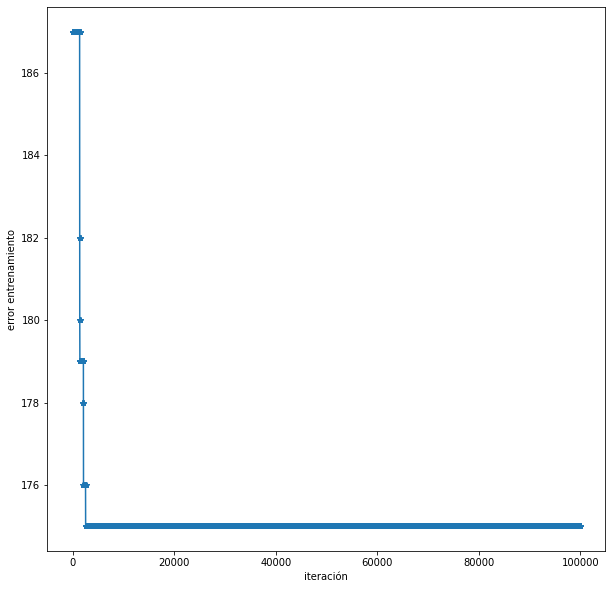

In [17]:
w_inicial = np.zeros(X.shape[1])
num_iteraciones = 100000
semilla = 42

inicio = time.time()
#######################################################
######## EMPIEZA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################

w_pocket, error_entrenamiento = entrenar_pocket(X, y, w0=w_inicial, max_iter=num_iteraciones, semilla=semilla)

#######################################################
######## TERMINA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################
fin = time.time()

print(error_entrenamiento[-1])
print(w_pocket)
print('El algoritmo pocket demoró %f segundos' % (fin - inicio))
print('El pocket finalizó en la iteración %d' % len(error_entrenamiento))
print('El error de entrenamiento es %f' % error_entrenamiento[-1])

validar_resultado("p02e02c", w_pocket)

# Se grafica el resultado del entrenamiento
visualizar_modelo_lineal(X, y, w_pocket)

plt.figure(figsize=(10, 10))
plt.plot(error_entrenamiento[100:], '*-')
plt.xlabel('iteración')
plt.ylabel('error entrenamiento')

* **Pregunta:** Mencione ventajas y desventajas que presenta el *algoritmo pocket* respecto al *perceptrón tradicional*

**Respuesta:**  La ventaja es que para datos no linealmente separables consigue quedarse con el vector w que menos errores deja en la cantidad máxima de iteraciones. Mientras que el algoritmo de perceptrón se queda con el último w el cual puede no ser el que deja la menor cantidad de errores. La desventaja 

## Regresión lineal para clasificación

Utilizar el método `regresion_lineal()` para obtener el vector de pesos $w_{ls}$. Comparar tiempo de ejecución y calidad de la solución obtenida con los del algoritmo pocket.

[-0.11255486 -0.02400059  0.10099327]
La regresión lineal demoró 0.000541 segundos
El error de clasificación utilizando la regresión lineal es 0.005916


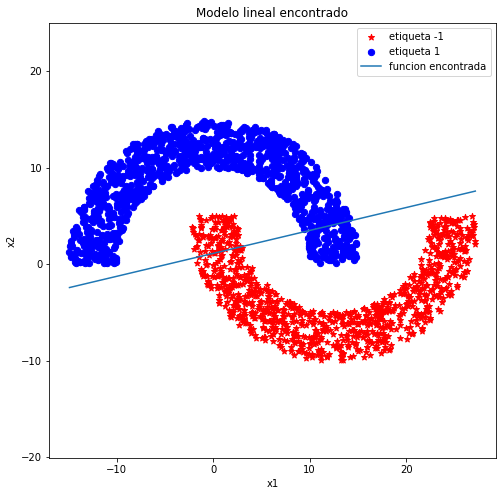

In [18]:
#######################################################
######## EMPIEZA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################

inicio = time.time()

w_ls = regresion_lineal(X,y) 

fin = time.time()

error_clasificacion = pow((np.dot(X,w_ls)-y),2)[-1]


#######################################################
######## TERMINA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################
print(w_ls)

print('La regresión lineal demoró %f segundos' % (fin - inicio))
print('El error de clasificación utilizando la regresión lineal es %f' %
      error_clasificacion)

# Se grafica el resultado del entrenamiento
visualizar_modelo_lineal(X, y, w_ls)

* **Pregunta:** Mencione las principales diferencias que observa entre los resultados obtenidos mediante regresión lineal y los obtenidos por el agoritmo pocket.  

**Respuesta:**  En el perceptrón la recta está junto a los datos mientras que en regresión lineal queda más separado

## Transformación no lineal de los datos

En esta sección se aplicará una transformación no lineal de los datos y luego se evaluará la performance de los clasificadores (pocket, regresión lineal) en el espacio transformado. La transformación se realizará utilizando el método `transformar_usando_polinomio_de_tercer_grado()`. Completar dicho método.

In [19]:
def transformar_usando_polinomio_de_tercer_grado(X):
    '''
    Entrada: 
        X: matriz de tamaño (N,3) que contiene las características originales en
           coordenadas homogéneas
    
    Salida:
        Xt: matriz de tamaño (N,10) que contiene las características en el espacio 
            transformado
            
            T(1,x1,x2)= (1, x1, x2, x1^2, x1x2, x2^2, x1^3, x1^2x2, x2^2x1, x2^3)
    '''

    #######################################################
    ######## EMPIEZA ESPACIO PARA COMPLETAR CODIGO ########
    #######################################################
    Xt=np.zeros((np.shape(X)[0],10))
    Xt[:,0]=X[:,0]
    Xt[:,1]=X[:,1]
    Xt[:,2]=X[:,2]
    Xt[:,3]=X[:,1]**2
    Xt[:,4]=X[:,1]*X[:,2]
    Xt[:,5]=X[:,2]**2
    Xt[:,6]=X[:,1]**3
    Xt[:,7]=Xt[:,3]*X[:,2]
    Xt[:,8]=Xt[:,5]*X[:,1]
    Xt[:,9]=X[:,2]**3
    #######################################################
    ######## TERMINA ESPACIO PARA COMPLETAR CODIGO ########
    #######################################################

    return Xt

Si la transformación encontrada es correcta la siguiente celda debería ejecutarse sin generar error.

In [20]:
# Validar implementación de la transformación no lineal de los datos.
# * Validar dimensión de datos transformados.
# * Validar transformación.
validar_resultado("transformacion",
                  funcion=transformar_usando_polinomio_de_tercer_grado)

+-------------------------------------------------------------------------+
| FuAA: validar resultado                                                 |
+-------------------------------------------------------------------------+
 Dimensión de salida: resultado validado.
 Transformación: resultado validado.
+-------------------------------------------------------------------------+


Utilizar el algoritmo pocket para separar los datos en el espacio transformado.

El w inicial es  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
El algoritmo pocket demoró 18.610523 segundos
El pocket finalizó en la iteración 100000
El error de entrenamiento es 104.000000


Text(0, 0.5, 'error entrenamiento')

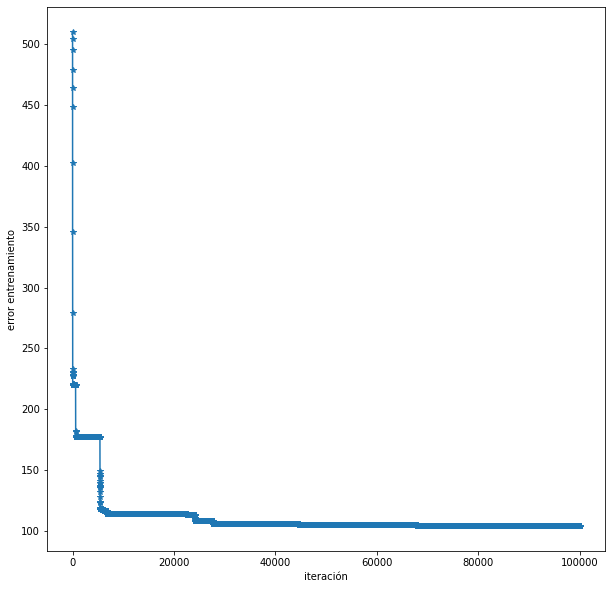

In [21]:
# Se transforman las características utilizando el método implementado
Xt = transformar_usando_polinomio_de_tercer_grado(X)

# Se inicializa con cero el vector de pesos en el espacio transformado
w_inicial_t = np.zeros(Xt.shape[1])

inicio = time.time()
#######################################################
######## EMPIEZA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################

w_pocket_t, error_entrenamiento = entrenar_pocket(Xt, y, w0=w_inicial_t, max_iter=num_iteraciones, semilla=semilla)

#######################################################
######## TERMINA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################
fin = time.time()

print('El algoritmo pocket demoró %f segundos' % (fin - inicio))
print('El pocket finalizó en la iteración %d' % len(error_entrenamiento))
print('El error de entrenamiento es %f' % error_entrenamiento[-1])

plt.figure(figsize=(10, 10))
plt.plot(error_entrenamiento[1:], '*-')
plt.xlabel('iteración')
plt.ylabel('error entrenamiento')

Es de esperar que la transformación no lineal de los datos haya contribuído a disminuir el error de clasificación durante el entrenamiento. Para ver cuáles son las muestras que   no pudieron clasificarse correctamente, ejecute la siguiente celda.

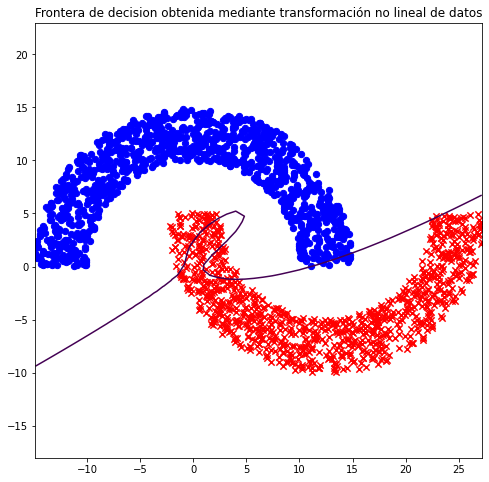

In [22]:
def visualizar_frontera_decision(X, y, w):
    '''
    Entrada:
        X: matriz de Nx3 que contiene los puntos en el espacio original
        y: etiquetas de los puntos
        w: vector de tamaño 10 que contiene los parámetros encontrados
    '''

    # Se construye una grilla de 50x50 en el dominio de los datos
    xs = np.linspace(X[:, 1].min(), X[:, 1].max())
    ys = np.linspace(X[:, 2].min(), X[:, 2].max())

    XX, YY = np.meshgrid(xs, ys)
    Z = np.zeros_like(XX)

    # se transforman los puntos de la grilla
    pts_grilla = np.vstack((np.ones(XX.size), XX.ravel(), YY.ravel())).T
    pts_grilla_transformados = transformar_usando_polinomio_de_tercer_grado(
        pts_grilla)

    # los puntos transformados son proyectados utilizando el w
    Z = pts_grilla_transformados @ w
    Z = Z.reshape(XX.shape)  #

    # se grafica la frontera de decisión, es decir, la línea de nivel 0
    plt.figure(figsize=(8, 8))
    plt.axis('equal')
    plt.contour(XX, YY, Z, [0])
    plt.scatter(X[:, 1][y == 1],
                X[:, 2][y == 1],
                s=40,
                color='b',
                marker='o',
                label='etiqueta -1')
    plt.scatter(X[:, 1][y == -1],
                X[:, 2][y == -1],
                s=40,
                color='r',
                marker='x',
                label='etiqueta 1')
    plt.title(
        'Frontera de decision obtenida mediante transformación no lineal de datos'
    )


visualizar_frontera_decision(X, y, w_pocket_t)

* **Pregunta:** Explique brevemente cómo se implementa el método `visualizar_frontera_decision`

**Respuesta:** 
...

Encontrar los parámetros del modelo de regresión lineal y calcular el error de clasificación cometido.

La regresión lineal demoró 0.001223 segundos
El error de clasificación utilizando la regresión lineal es 0.001213


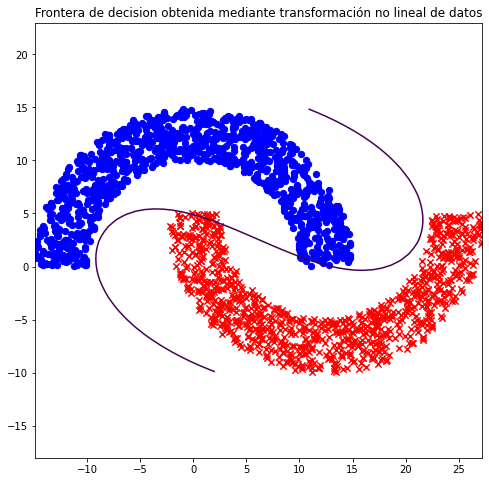

In [23]:
inicio = time.time()
#######################################################
######## EMPIEZA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################

w_ls_t = regresion_lineal(Xt,y)

error_ls_t = pow((np.dot(Xt,w_ls_t)-y),2)[-1]

#######################################################
######## TERMINA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################
fin = time.time()

print('La regresión lineal demoró %f segundos' % (fin - inicio))

print('El error de clasificación utilizando la regresión lineal es %f' %
      error_ls_t)
visualizar_frontera_decision(X, y, w_ls_t)

* **Pregunta:** Compare ambos algoritmos en términos de performance y costo computacional

**Respuesta:**   ...

* **Pregunta:** ¿Son los datos linealmente separables en el espacio transformado?

**Respuesta:** ... 

# Ejercicio 3: Clasificación de dígitos
<a id="Ejercicio3"></a>

En esta parte se trabajará con la base USPS de dígitos disponible en [kaggle](https://www.kaggle.com/bistaumanga/usps-dataset).
Cada dígito corresponde a una imagen de dimensiones 16x16, que se guarda como un vector de largo 16x16, con codificación binaria (cada pixel vale 0 o 1). 
A continuación se cargan los datos y se muestra una imagen de cada dígito.

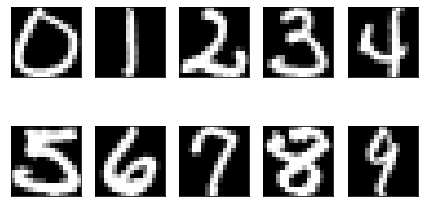

In [24]:
path = 'usps/usps.h5'

with h5py.File(path, 'r') as hf:
    train = hf.get('train')
    X_train = train.get('data')[:]
    y_train = train.get('target')[:]
    test = hf.get('test')
    X_test = test.get('data')[:]
    y_test = test.get('target')[:]

# Se deberían ver 2 x 5 subfiguras con una imagen
# representativa de cada dígito

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(16, 16)
    ax[i].imshow(img, cmap='gray')
    ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

En esta práctica se trabajará con los dígitos uno y cinco. La función `generar_problema_dos_clases()` es la encargada de generar, a apartir de las características y etiquetas originales, un conjunto de datos listos para ser utilizados en un problema de clasificación de dos clases. 

In [25]:
def generar_problema_dos_clases(X, y, clase1, clase2):
    '''
    Entrada: 
        X: matriz de dígitos
        y: etiquetas asociadas a los dígitos
        clase1: lista con los dígitos a los que se le asignará la clase 1
        clase2: lista con los dígitos a los que se le asignará la clase -1
    Salida:
        Xb: matriz que contiene únicamente las características de los dígitos 
            clase1 y clase 2
        yb: etiquetas asignadas a los dígitos clase1 y clase2 (1 o -1)
    '''

    indicesClase1 = [etiqueta in clase1 for etiqueta in y]
    indicesClase2 = [etiqueta in clase2 for etiqueta in y]

    clase1 = X[indicesClase1]
    clase2 = X[indicesClase2]

    Xb = np.vstack((clase1, clase2))
    yb = np.ones(len(Xb), dtype=int)
    yb[len(clase1):] *= -1

    return Xb, yb

El siguiente bloque genera datos de entrenamiento y test para el problema de clasificación entre unos y cincos.

In [26]:
clase1 = [1]
clase2 = [5]
Xb_train, yb_train = generar_problema_dos_clases(X_train, y_train, clase1,
                                                 clase2)
Xb_test, yb_test = generar_problema_dos_clases(X_test, y_test, clase1, clase2)

## Generación de características para clasificar digitos

En vez de trabajar con los valores de los píxeles como características se generará una representación de los dígitos mucho más compacta. Completar el código de la función `caracterizar_digitos(digitos)`, la misma genera una representación de los dígitos utilizando solamente dos características.  En principio de utilizará la simetría y la intensidad promedio como se discutió en clase aunque se alienta a evaluar otras opciones. 

$$
\begin{align}
intensidad &= \frac{1}{256}\sum_{m=0}^{15}\sum_{n=0}^{15}I(m,n)  \\
simetria &= 1 - \frac{1}{256}\sum_{m=0}^{15}\sum_{n=0}^{15} \frac{ \vert I(m,n)- I(m,15 - n) \vert + \vert I(m,n)- I(15-m, n)\vert}{2} \\
         &= \frac{\text{simetria horizontal}+\text{simetria vertical}}{2}
\end{align}
$$

Verificar que los valores obtenidos se encuentran dentro del rango [0,1].

In [27]:
def caracterizar_digitos(digitos):
    '''
    Genera las características que se utilizarán para clasificar los dígitos
    Entrada:
        digitos: arreglo de (N,256) que contiene N dígitos
    Salida:
        features: arreglo de (N,2) con las característcas calculadas. En principio se 
                  sugiere calcular la intensidad promedio y una medida de simetría, 
                  pero podría calcularse alguna otra medida.
    '''
    N = digitos.shape[0]
    features = np.zeros((N, 2))  # vector que almacena las características generadas

    #######################################################
    ######## EMPIEZA ESPACIO PARA COMPLETAR CODIGO ########
    #######################################################
    simetria_horizontal=[]
    simetria_vertical=[]
    # se calcula la primera característica, por ejemplo la intensidad promedio
    intensidad = np.mean(digitos,axis=1)

    # se calcula la segunda característica, por ejemplo la simetría
    # Previo al cálculo de las simetrías puede ser útil np.reshape()
    # para transformar el vector de entrada de tamaño Nx256 en uno de Nx16x16
    digitos_rs=np.reshape(digitos,((N*16),16))
    #simetria_horizontal=(np.mean(np.reshape(abs(digitos_rs[:,0:7]-digitos_rs[:,8:16][:,::-1]),(N,128)),axis=1))/2
    for i in range(N) :
        digitos_16x16=digitos_rs[i*16:((i+1)*16),:]
        simetria_horizontal.append(np.mean(abs(digitos_16x16[:,0:8]-digitos_16x16[:,8:16][:,::-1])))
        simetria_vertical.append(np.mean(abs(digitos_16x16[0:8,:]-digitos_16x16[8:16,:][::-1,:])))
        
    simetría = 1 - np.add(simetria_horizontal,simetria_vertical)/2

    features[:,0] = intensidad
    features[:,1] = simetría

    #######################################################
    ######## TERMINA ESPACIO PARA COMPLETAR CODIGO ########
    #######################################################

    return features

El siguiente bloque calcula las características y las grafica utilizando un scatter 2D.

+-------------------------------------------------------------------------+
| FuAA: validar resultado                                                 |
+-------------------------------------------------------------------------+
 Dimensiones de las características de entrenamiento: resultado validado.
 Dimensiones de las características de test: resultado validado.
 Características de entrenamiento: resultado validado.
 Características de test: resultado validado.
+-------------------------------------------------------------------------+


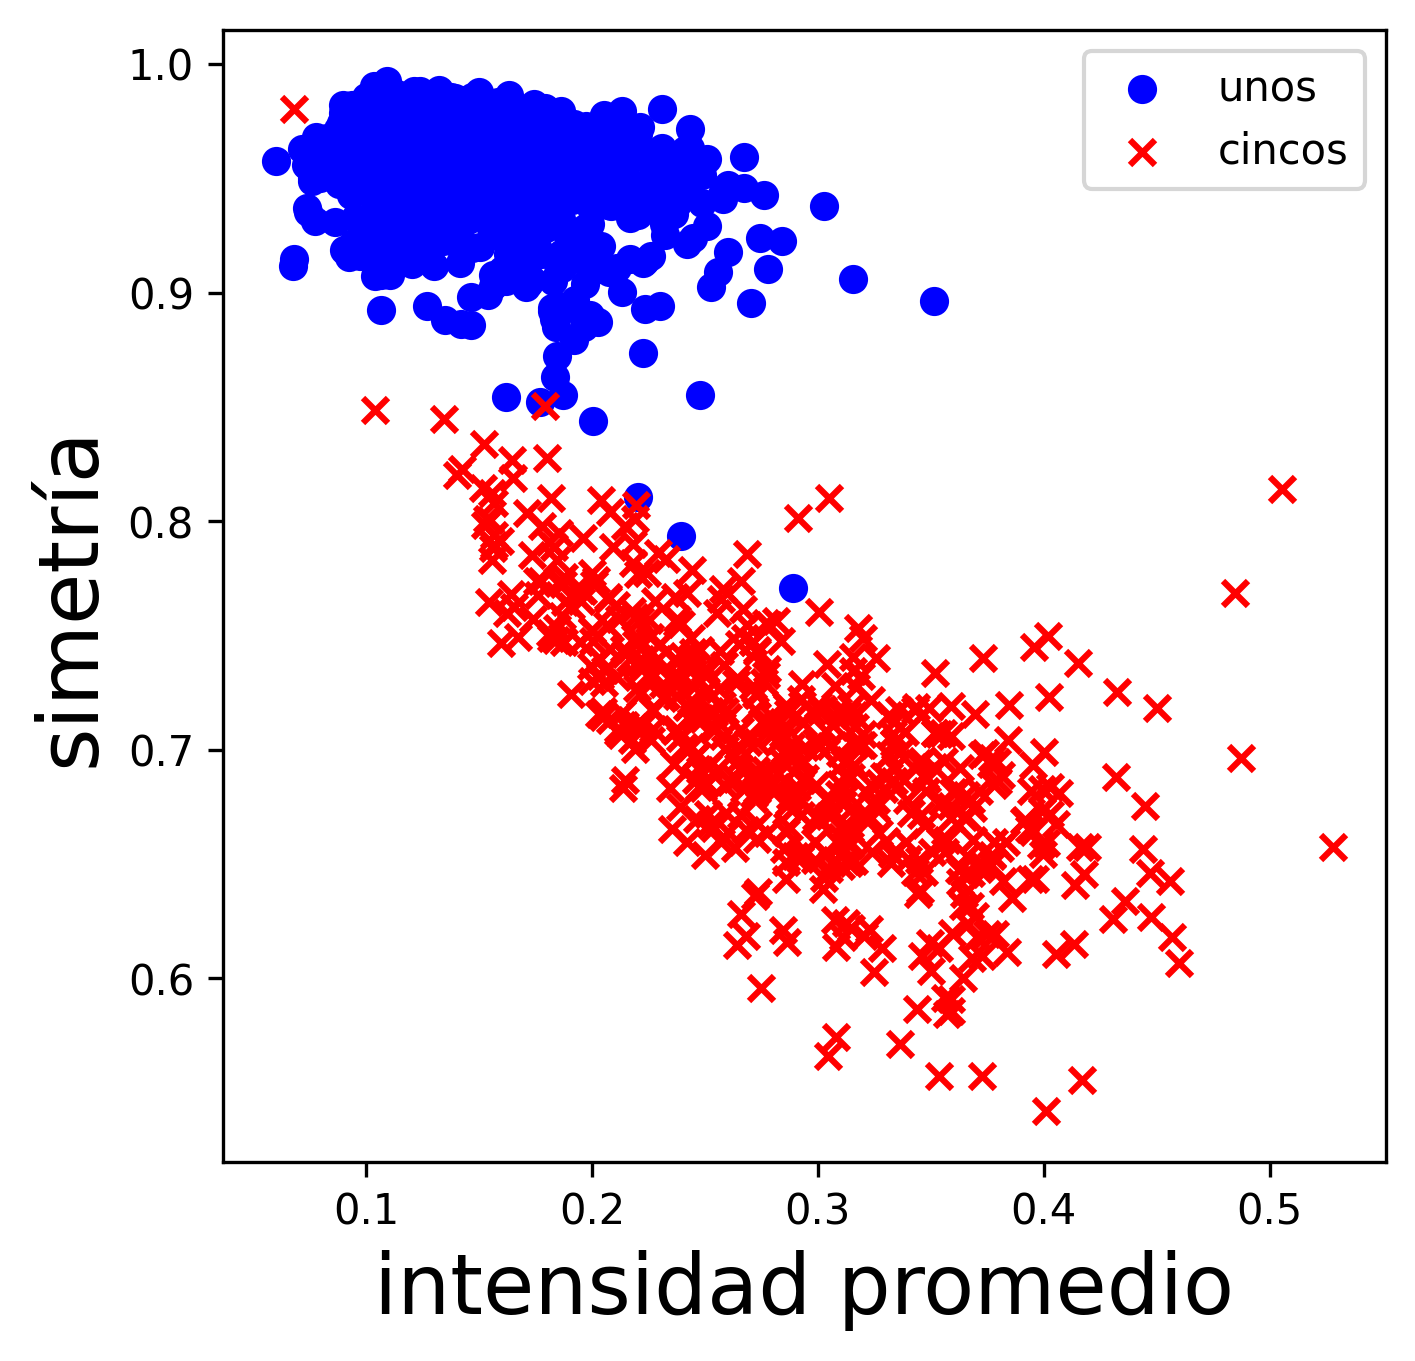

In [28]:
featuresTrain = caracterizar_digitos(Xb_train)
featuresTest = caracterizar_digitos(Xb_test)

# nombres de las características utilizadas
nombresCaracterísticas = ['intensidad promedio', 'simetría']
# nombres de los dígitos a separar
nombresClases = ['unos', 'cincos']

plt.figure(figsize=(5, 5), dpi=300)
plt.scatter(featuresTrain[yb_train == 1, 0],
            featuresTrain[yb_train == 1, 1],
            color='b',
            marker='o',
            label=nombresClases[0])
plt.scatter(featuresTrain[yb_train == -1, 0],
            featuresTrain[yb_train == -1, 1],
            color='r',
            marker='x',
            label=nombresClases[1])
plt.xlabel('intensidad promedio', fontsize=20)
plt.ylabel('simetría', fontsize=20)
plt.legend()

# Validar características calculadas.
validar_resultado("digitos", featuresTrain, featuresTest)

* **Pregunta:** Una de las muestras toma valores muy diferentes a los que toman las demás muestras de su clase. ¿Cambiaría esto si se utiliza otra caracterización del dígito? Sugerencia: mostrar el dígito que genera la caracterización anómala   

**Respuesta:** No, porque el dígito no se parece en nada al que debería ser entonces no hay forma de clasificarlo bien

Los algoritmos vistos hasta el momento en el curso utilizan una representación de los datos en coordenadas homogéneas. El siguiente bloque realiza la conversión.

In [29]:
# las características tienen que estar en coordenadas homogeneas
featuresH_train = np.ones((featuresTrain.shape[0], featuresTrain.shape[1] + 1))
featuresH_train[:, 1:] = featuresTrain

## Clasificación de los dígitos utilizando el perceptrón

Completar el siguiente bloque de código para que entrene un perceptrón durante 100000 iteraciones utilizando como vector inicial de pesos el vector de ceros. 

El algoritmo perceptrón demoró 3.924665 segundos
El perceptrón finalizó en la iteración 100000
El error de entrenamiento es 20.000000


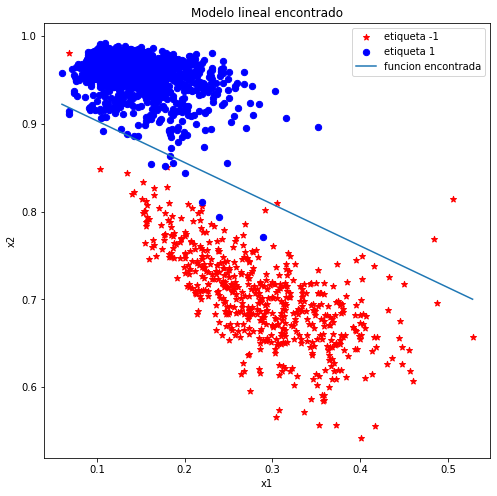

In [30]:
# Clasificación de los dígitos utilizando el perceptrón
w_inicial = np.zeros(featuresH_train.shape[1])
numIteraciones = 100000

inicio = time.time()
#######################################################
######## EMPIEZA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################

w_perceptron, error_perceptron = entrenar_perceptron(featuresH_train, yb_train, w_inicial=w_inicial, max_iter=numIteraciones)

#######################################################
######## TERMINA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################
fin = time.time()

print('El algoritmo perceptrón demoró %f segundos' % (fin - inicio))
print('El perceptrón finalizó en la iteración %d' % len(error_perceptron))
print('El error de entrenamiento es %f' % error_perceptron[-1])

# Se grafica el resultado del entrenamiento
visualizar_modelo_lineal(featuresH_train, yb_train, w_perceptron)

## Clasificación de los dígitos utilizando el pocket

Completar el siguiente bloque de código para que entrene el algoritmo pocket durante 100000 iteraciones utilizando como vector inicial de pesos el vector de ceros. 

El w inicial es  [0. 0. 0.]
El algoritmo pocket demoró 4.018956 segundos
El pocket finalizó en la iteración 100000
El error de entrenamiento es 5.000000


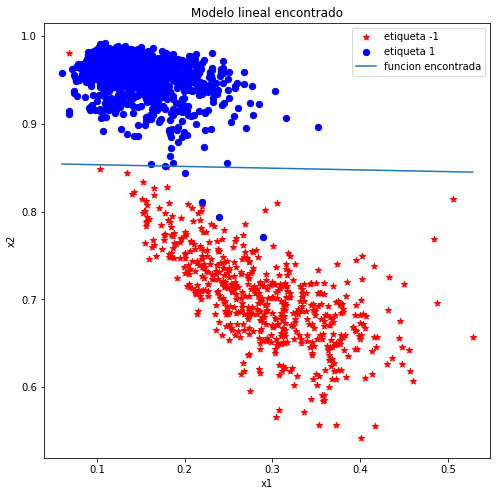

In [31]:
w_inicial = np.zeros(featuresH_train.shape[1])
numIteraciones = 100000
# Se entrena el algoritmo pocket
inicio = time.time()

#######################################################
######## EMPIEZA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################

w_pocket, error_pocket = entrenar_pocket(X=featuresH_train, y=yb_train, w0=w_inicial, max_iter=numIteraciones)

#######################################################
######## TERMINA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################
fin = time.time()

print('El algoritmo pocket demoró %f segundos' % (fin - inicio))
print('El pocket finalizó en la iteración %d' % len(error_pocket))
print('El error de entrenamiento es %f' % error_pocket[-1])

# Se grafica el resultado del entrenamiento
visualizar_modelo_lineal(featuresH_train, yb_train, w_pocket)

## Transformación no lineal de dígitos

Utilizar el algoritmo pocket para separar los digitos en el espacio transformado. Graficar la frontera de decisión encontrada.

El w inicial es  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


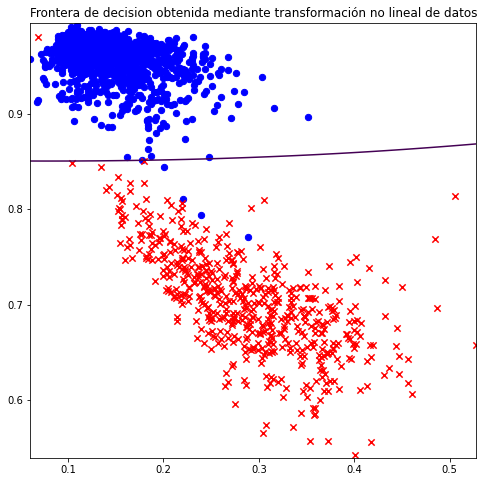

In [32]:
featuresHT_train = transformar_usando_polinomio_de_tercer_grado(
    featuresH_train)
w_inicial_t = np.zeros(featuresHT_train.shape[1])
numIteraciones = 100000

#######################################################
######## EMPIEZA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################

w_pocket_t, error_pocket_t = entrenar_pocket(X=featuresHT_train, y=yb_train, w0=w_inicial_t, max_iter=numIteraciones)

#######################################################
######## TERMINA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################
# Se grafica el resultado del entrenamiento
visualizar_frontera_decision(featuresH_train, yb_train, w_pocket_t)

* **Pregunta:** Si fuera inminente la puesta en producción del clasificador de unos y ceros. ¿Qué algoritmo utilizaría?

**Respuesta:**  ...

## Evaluar con el conjunto de test

Evalúe el desempeño del *algoritmo pocket* en el conjunto de test en ambos casos.

El w inicial es  [0. 0. 0.]
20
El w inicial es  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
20


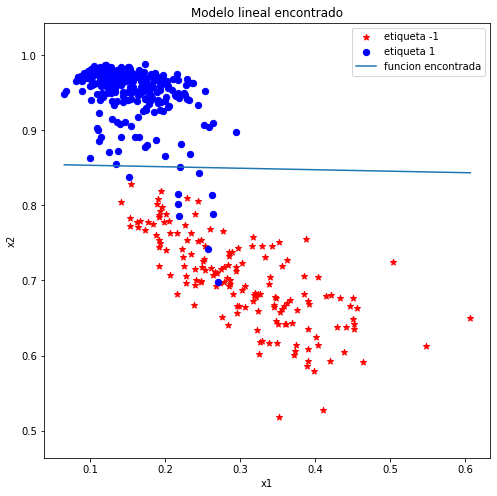

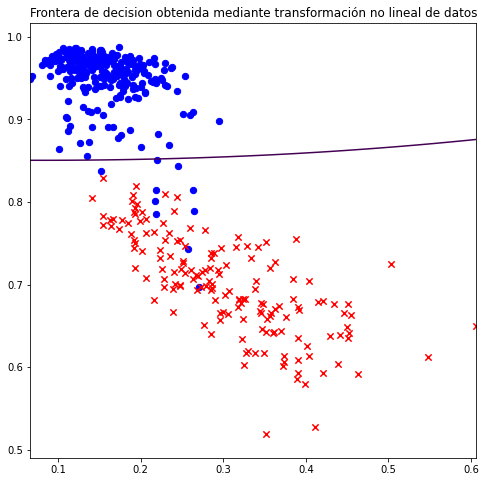

In [39]:
featuresH_test = np.ones((featuresTest.shape[0], featuresTest.shape[1] + 1))
featuresH_test[:, 1:] = featuresTest

#######################################################
######## EMPIEZA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################

# Se evalúa el algoritmo pocket en el espacio original
w_pocket, error_pocket= entrenar_pocket(X=featuresH_train, y=yb_train, w0=w_inicial, max_iter=numIteraciones)
w_perceptron, error_entrenamiento = entrenar_perceptron(X=featuresH_train, y=yb_train, w_inicial=w_inicial, max_iter=numIteraciones)
print(error_entrenamiento[-1])
# Se grafica el resultado
visualizar_modelo_lineal(featuresH_test, yb_test, w_pocket)

# Se evalúa el algoritmo pocket en el espacio transformado
featuresHT_test = transformar_usando_polinomio_de_tercer_grado(featuresH_test)
w_inicial_t = np.zeros(featuresHT_test.shape[1])
w_pocket_t, error_pocket_t = entrenar_pocket(X=featuresHT_train, y=yb_train, w0=w_inicial_t, max_iter=numIteraciones)
w_perceptron, error_entrenamiento = entrenar_perceptron(X=featuresHT_train, y=yb_train, w_inicial=w_inicial_t, max_iter=numIteraciones)
print(error_entrenamiento[-1])
# Se grafica el resultado en el espacio transformado
visualizar_frontera_decision(featuresHT_test, yb_test, w_pocket_t)

#######################################################
######## TERMINA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################

## Evaluación interactiva 

A continuación se plantea realizar una evaluación interactiva del funcionamiento del clasificador de dígitos. Se reconocerán los dígitos dibujados sobre el *sketchpad* de la biblioteca [gradio](https://www.gradio.app/).    

La función `preprocesar()` provista en la siguiente celda, realiza la conversión de la imágenes generadas con el *sketchpad* al formato de los datos de entrenamiento. A diferencia de los datos de entrenamiento, los dígitos en el *sketchpad* de *gradio* son negros sobre fondo blanco, tomando el blanco el valor 0 y el negro el 255.

In [1]:
def preprocesar(img):
    # Se reescala la imagen al tamaño de los dígitos de entrenamiento
    img = interpolation.zoom(img, 16 / img.shape[1])
    # Se normaliza de [0, 255] ->[0,1]
    img = img / 255
    # Se invierten los valores (0,1) -> (1,0)
    # img = 1 - img
    return img.reshape(1, 16 * 16).astype(float)

Complete la función `reconocer_digito()` de forma tal que la función utilice los pesos **w_pocket** para realizar la clasificación. 

In [40]:
def reconocer_digito(img):
    '''
    Clasifica una imagen de entrada de MxM y devuelve un diccionario
    con el valor de las características calculadas sobre la imagen
    y el digito asignado a la imagen. 
    Entrada:
        img: matriz (imagen) de MxM devuelta por el sketchpad que contiene el dígito a clasificar
    
    Salida:
        Diccionario que contiene:
        {intensidad: valor de intensidad del digito,
         simetria: valor de simetria del digito,
         score: valor del score o señal asignado a este dígito por w_produccion,
         nombre_prediccion: nombre asociado a la prediccion realizada por el clasificador. 
                            Es uno de los elementos de la lista de entrada nombre_clases.
        }
        
    '''
    # En este caso los dígitos a separar son uno y cinco
    nombre_clases = ['1', '5']

    # se preprocesa la imagen para obtener una imagen de 16x16
    # similar a las de entrenamiento
    img = preprocesar(img)

    # Se calculan las caracteristicas
    features = np.ones(3)
    features[1:] = caracterizar_digitos(img)

    ###########################################################
    ########  Empieza espacio para completar código ###########
    ###########################################################

    # Se calcula la señal o el score para este digito
    # ~ 1 linea de código intensidad-simetría
    score =np.sign(np.dot(w_pocket,features))

    # Se calcula la predicción
    # ~ 1 linea de código
    prediccion = score

    ###########################################################
    ########  Termina espacio para completar código ###########
    ###########################################################

    nombre_prediccion = nombre_clases[0] if prediccion > 0 else nombre_clases[1]

    return [{
        'intensidad': features[1],
        'simetria': features[2],
        'score': score
    }, nombre_prediccion]

La siguiente celda crea un widget interactivo que permite dibujar dígitos. Evalúe el desempeño del algoritmo para distintas entradas.

Los tres círculos situados arriba del área de dibujo permiten variar el grosor de línea. Describa como varía el desempeño del modelo al cambiarlo, y a qué se debe.

In [41]:
output_label = gr.outputs.Label(num_top_classes=None,
                                label='El garabato se parece a:')
gr.Interface(fn=reconocer_digito,
             inputs='sketchpad',
             title='Clasificador de dígitos',
             outputs=["json", output_label]).launch()

/home/jess/miniconda3/envs/fuaa/lib/python3.8/site-packages/gradio/outputs.py:196: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/home/jess/miniconda3/envs/fuaa/lib/python3.8/site-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860/

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x7f6b46610550>, 'http://127.0.0.1:7860/', None)

/tmp/ipykernel_9892/2793844106.py:3: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  img = interpolation.zoom(img, 16 / img.shape[1])
/tmp/ipykernel_9892/2793844106.py:3: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  img = interpolation.zoom(img, 16 / img.shape[1])
/tmp/ipykernel_9892/2793844106.py:3: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  img = interpolation.zoom(img, 16 / img.shape[1])
/tmp/ipykernel_9892/2793844106.py:3: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  img = interpolation.zoom(img, 16 / img.shape[1])
/tmp/ipykernel_9892/2793844106.py:3: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `

**Respuesta:**

## Separación del uno de los demás digitos 

¿La representación de los dígitos utilizada en el ejercicio es adecuada para separar el uno de los demás digitos? Evalúelo con los datos que tiene disponible.